In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laspy.file import File

# Necessary to import pypwaves_updated.py from parent directory
import sys
sys.path.append('../')
import pypwaves_updated as pw

%matplotlib inline

## Comparing with LAS file
GPS timestamps kind of line up...the overall timeframe is identical to ~5 digits, but the offset is very different and the points don't line up exactly.  Also the point counts don't align, even accounting for pulses with multiple returns in the .las file.

In [2]:
# Adj GPS Time: Set both timestamps to zero for the first record
def adjust_time(df,time_field):
    # Function adds adj_gps_time to points or pulse dataframe, set to zero at the minimum timestamp.
    df['adj_gps_time'] = df[time_field] - df[time_field].min()
    return df

def label_returns(las_df):
    '''
    Parses the flag_byte into number of returns and return number, adds these fields to las_df.
    Input - las_df - dataframe from .laz or .lz file
    Output - first_return_df - only the first return points from las_df.
           - las_df - input dataframe with num_returns and return_num fields added 
    '''
    
    las_df['num_returns'] = np.floor(las_df['flag_byte']/16).astype(int)
    las_df['return_num'] = las_df['flag_byte']%16
    first_return_df = las_df[las_df['return_num']==1]
    first_return_df = first_return_df.reset_index(drop=True)
    return first_return_df, las_df

In [3]:
# Load LAS points
las_df = pd.read_hdf("../../Data/parking_lot/las_points_172753.lz")

# Load pls anchor points
pls_anchor_df = pd.read_pickle("../../Data/pickles/anchors_172753.pkl")


# Separate out the first returns only
las_df = adjust_time(las_df,'gps_time')
pls_anchor_df = adjust_time(pls_anchor_df,'gps_time')

# Sort records by timestamp
las_df.sort_values(by=['adj_gps_time'],inplace=True)
pls_anchor_df.sort_values(by=['adj_gps_time'],inplace=True)

# Reset indices
las_df.reset_index(drop=True,inplace=True)
pls_anchor_df.reset_index(drop=True,inplace=True)

In [4]:
first_return_df, las_df = label_returns(las_df)
print("Number of points in .las file: {:,d}".format(las_df.shape[0]))
print("Number of first return points: {:,d}".format(first_return_df.shape[0]))
print("Number of pulses in .pls file: {:,d}".format(pls_anchor_df.shape[0]))

Number of points in .las file: 12,028,738
Number of first return points: 10,968,702
Number of pulses in .pls file: 9,089,361


### Comparing Timestamps
The timespan for the two files agree almost exactly.  
LAS file uses seconds since midnight Saturday night.  
PLS file uses GPS Week Time (seconds since midnight on previous Sunday night).  
Oddly, the files are still phased by 18 seconds, even after accounting for the 6-day offset.

In [7]:
# Compare time ranges
las_range = (first_return_df['gps_time'].min(),first_return_df['gps_time'].max())
anchor_range = (pls_anchor_df['gps_time'].min(),pls_anchor_df['gps_time'].max())

print("LAS range: {:2.3f} seconds".format(las_range[1]-las_range[0]))
print("PLS range: {:2.3f} seconds".format(anchor_range[1]-anchor_range[0]))

LAS range: 51.932 seconds
PLS range: 51.932 seconds


In [2]:
# First bit of Global Encoding indicates the gps time model: 0 for GPS Week Time, 
# 1 for GPS Adj Standard Time (Standard Time - 1e9)
# The origin of standard GPS Time is defined as midnight of the morning of January 6, 1980.
print(inFile.header.global_encoding%2)

NameError: name 'inFile' is not defined

In [8]:
# Checking the GPS encoding for LAS file - Type 0 indicates GPS Week Time, otherwise GPS Adjusted Time.
# This seems to mean GPS Week Time
#print("LAS time type: ",las_header.header.get_gps_time_type())

print("\nLAS:")
print("GPS Time at start of run: {:2.3f} days".format(las_range[0]/ (60*60*24)))
# So the run was probably on a Sunday?
print("\nPLS:")
print("GPS Time at start of run: {:2.3f} days".format(anchor_range[0]/(60*60*24)))


LAS:
GPS Time at start of run: 0.728 days

PLS:
GPS Time at start of run: 6.728 days


In [9]:
# Oddly, the files are still phased by 18 seconds
print("Difference in timestamps, accounting for GPS convention: {:2.2f} seconds".format(
                        anchor_range[0] - las_range[0] - (6*24*60*60)))

Difference in timestamps, accounting for GPS convention: -18.00 seconds


## Extract points with no corresponding pulse
Points that don't have a pulse within $\pm \epsilon$ seconds.

In [10]:
# For each point, find the pulse at the closest 
# previous (or equal) timestamp
pls_indices = np.searchsorted(pls_anchor_df['adj_gps_time'],
                             first_return_df['adj_gps_time'])-1

In [11]:
# Only the nearest point can associate with a given pulse.
pls_indices[0] = 0
for i,pls in enumerate(pls_indices[1:]):
    if pls_indices[i] == pls_indices[i-1]:
        pls_indices[i] = 0

In [12]:
# Calculate time difference between each point and closest pulse
epsilon = .000001 # This is too loose, but it works for just looking at points that clearly have no pulse.
time_diff = np.array(first_return_df['adj_gps_time']) - \
            np.array(pls_anchor_df['adj_gps_time'].iloc[pls_indices])

# If time difference > epsilon, set pls_index to zero
for i,t in enumerate(time_diff):
    if t > epsilon:
        pls_indices[i] = 0

In [13]:
first_return_df['pulse_index'] = pls_indices

# Points without pulses
no_pulse = first_return_df[first_return_df['pulse_index']==0]
with_pulse = first_return_df[first_return_df['pulse_index']>0]

# Find pulses with no point
pulse_with_point = pls_anchor_df.iloc[with_pulse['pulse_index']]
pulse_without_point = pls_anchor_df.drop(with_pulse['pulse_index'])

In [14]:
print("Fraction of points without a corresponding pulse: {:2.4f}".format(sum(pls_indices==0)/pls_indices.shape[0]))

Fraction of points without a corresponding pulse: 0.6998


## Time between returns
Looking at the typical timing between first, second, nth returns for the same pulse.  
Result: All associated returns have the exact same timestamp!  

In [15]:
returns_from_same_pulse = las_df.iloc[336020:336028]
print("Timestamp range of 8 returns for same pulse: {:2.5f} seconds".format(returns_from_same_pulse['gps_time'].max()-returns_from_same_pulse['gps_time'].min()))
las_df.iloc[336020:336028][['num_returns','return_num','gps_time']] 

Timestamp range of 8 returns for same pulse: 0.00000 seconds


,num_returns,return_num,gps_time
336020,8,7,62894.671137
336021,8,6,62894.671137
336022,8,8,62894.671137
336023,8,5,62894.671137
336024,8,2,62894.671137
336025,8,3,62894.671137
336026,8,1,62894.671137
336027,8,4,62894.671137


In [16]:
# Q: Are multi-return points less likely to line up with a pulse?
# A: No.
print("Mean number of returns for points \nwith/without a corresponding pulse\n"+"*"*40)
print("Points with no pulse: {:2.4f} returns".format(no_pulse['num_returns'].mean()))
print("Points with pulse: {:2.4f} returns".format(with_pulse['num_returns'].mean()))
print("Overall: {:2.4f} returns".format(first_return_df['num_returns'].mean()))

Mean number of returns for points 
with/without a corresponding pulse
****************************************
Points with no pulse: 1.0961 returns
Points with pulse: 1.0979 returns
Overall: 1.0966 returns


In [17]:
# Q: Are pulses without a point more likely to be noisy (anchor above or below expected helicopter altitude)?  
# A: No they are not
print("All pulses, % that are noisy:: {:2.4%}".format((sum(pls_anchor_df['z']>1100) + sum(pls_anchor_df['z']< 600))/pls_anchor_df.shape[0]))
print("Pulses with points: {:2.4%}".format((sum(pulse_with_point['z']>1100) + sum(pulse_with_point['z']< 600))/pulse_with_point.shape[0]))
print("Pulses without points: {:2.4%}".format((sum(pulse_without_point['z']>1100) + sum(pulse_without_point['z']< 600))/pulse_without_point.shape[0]))   


All pulses, % that are noisy:: 56.5237%
Pulses with points: 56.4620%
Pulses without points: 56.5587%


## Temporal Distribution Plotting
Tooling, then comparing temporal distribution of points with and without a corresponding pulse.

In [18]:
def create_bins(df,ms_per_bin,time_field='adj_gps_time'):
    '''Function returns a numpy array of bin edges, 
    where the number of bins = (max_time - min_time)*1e/ms_per_bin 
    where time is in seconds.'''
    min_val = int(np.floor(df[time_field]*1e3).min())
    max_val = int(np.ceil(df[time_field]*1e3).max())
    bin_range = range(min_val,max_val,ms_per_bin)
    bin_arr = np.array(bin_range)/1e3
    return bin_arr

def plot_range(df,first_point,last_point,ms_per_bin):
    '''
    Plots the temporal density and the specific points within the [first_point,last_point] range.
    Vertical lines are the bin edges
    Red dots are the points within the bin edges
    Blue is the distribution of the points
    '''
    bin_plot = create_bins(df[first_point:last_point],ms_per_bin)
    hist_plot,_ = np.histogram(df['adj_gps_time'][first_point:last_point],bin_plot)
    plt.figure(figsize=[18,12])
    plt.plot(df['adj_gps_time'][first_point:last_point], \
             hist_plot.mean()*np.ones(last_point-first_point), "x",markersize=8,label="Points")
    plt.plot(bin_plot[:-1]+(ms_per_bin/2000),hist_plot,"ro",markersize=12,label="Points in bin")
    plt.vlines(bin_plot,hist_plot.min(),hist_plot.max(),linestyle=":",color='coral',label="Bin edges")
    
    plt.xlabel("Time in Seconds",fontsize=15)
    plt.ylabel("Points per {}ms bin".format(ms_per_bin),fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()

def points_per_scan(scan_angle):
    '''takes scan_angle as Series, counts the number of "jumps" in the scan angle, indicating start of a new scan
    then divides the number of points in scan_angle to return points / scan'''
    delta_angle = [scan_angle.iloc[i+1]-scan_angle.iloc[i] for i in range(len(scan_angle)-1)]
    print("Done")
    scan_count = sum(abs(np.array(delta_angle)) > scan_angle.max())
    print("Number of scans: {}".format(scan_count))
    print("Points per scan: {:2.2f}".format(len(scan_angle)/scan_count))    
    return len(scan_angle)/scan_count, scan_count

def scan_temporal_profile(df):
    '''
    Identifies each scan by the reset in scan_angle, calculates mean and SD for each of: 
    - time of each scan
    - time of each gap
    - points in each scan 
    Input: Full points dataframe
    '''
    df.reset_index(inplace=True)
    delta_angle=[0]
    delta_angle.extend([df['scan_angle'].iloc[i+1]-df['scan_angle'].iloc[i] for i in range(df.shape[0]-1)])
    df['delta_angle'] = delta_angle
    first_pts = df[abs(df['delta_angle'])>df['scan_angle'].max()]
    fpi = first_pts.index
    
    gap_times = np.array(df.iloc[fpi]['adj_gps_time']) - np.array(df.iloc[fpi-1]['adj_gps_time'])
    total_cycle_times = np.array(df.iloc[fpi[1:]]['adj_gps_time']) - np.array(df.iloc[fpi[:-1]]['adj_gps_time'])
    scan_times = total_cycle_times - gap_times[:-1]
    print("Gap Time Mean (ms): ",gap_times.mean()*1000)
    print("Gap Time StdDev (ms): ",gap_times.std()*1000)    
    print("Scan Time Mean (ms): ",scan_times.mean()*1000)
    print("Scan Time StdDev (ms): ",scan_times.std()*1000)    

    # Pts per scan distribution
    pts_per_scan = np.array([fpi[i] - fpi[i-1] for i in range(1,len(fpi))])
    print("Points per Scan Mean: ",pts_per_scan.mean())
    print("Points per Scan StdDev: ",pts_per_scan.std())    

In [19]:
# Profiling the cycles while over land
scan_temporal_profile(first_return_df[:500000])

Gap Time Mean (ms):  2.5041295692062704
Gap Time StdDev (ms):  0.0031541116294580437
Scan Time Mean (ms):  4.997324961364363
Scan Time StdDev (ms):  0.005771298256622044
Points per Scan Mean:  1918.7374517374517
Points per Scan StdDev:  11.059360143706837


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


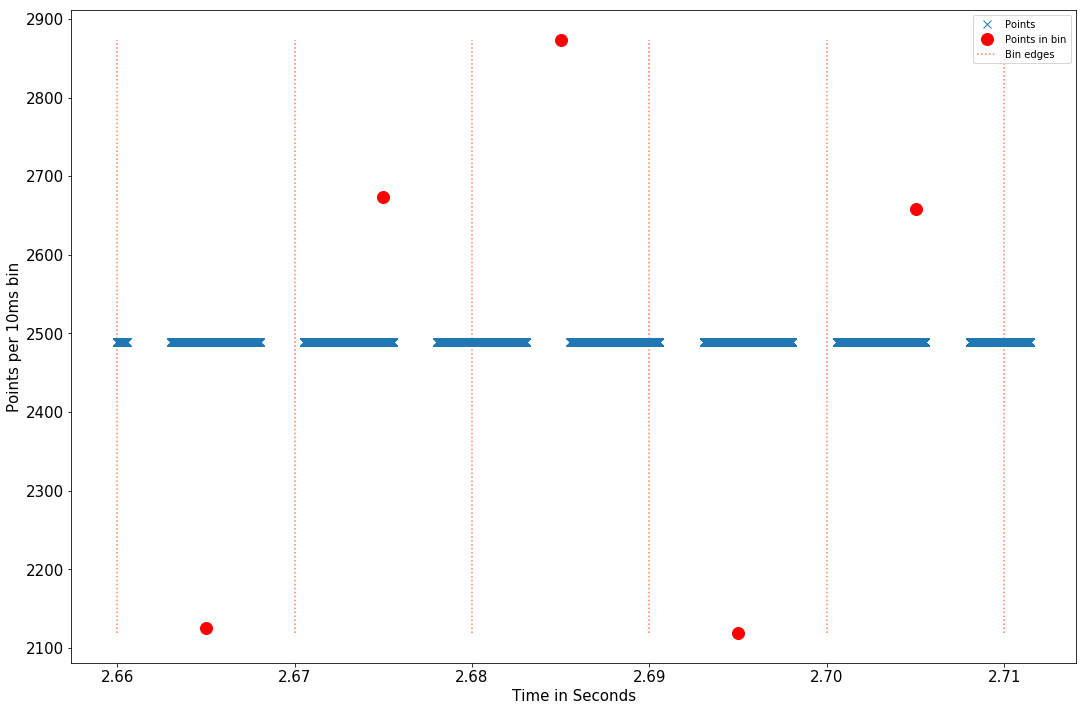

In [20]:
# Plots the window/cycle phasing problem
first_point = 681048
last_point =  first_point+13000

plot_range(first_return_df,first_point,last_point,ms_per_bin=10)

In [21]:
# Create the bin edges
bin_arr = create_bins(first_return_df,ms_per_bin=45)

# Use np.histogram to find the number of points per bin
hist,_ = np.histogram(first_return_df['adj_gps_time'],bin_arr)
hist_no_pulse,_ = np.histogram(no_pulse['adj_gps_time'],bin_arr)
hist_with_pulse,_ = np.histogram(with_pulse['adj_gps_time'],bin_arr)
# Same for Pulses
hist_pulse,_ = np.histogram(pls_anchor_df['adj_gps_time'],bin_arr)
hist_pls_with_pt,_ = np.histogram(pulse_with_point['adj_gps_time'],bin_arr)
hist_pls_no_pt,_ = np.histogram(pulse_without_point['adj_gps_time'],bin_arr)

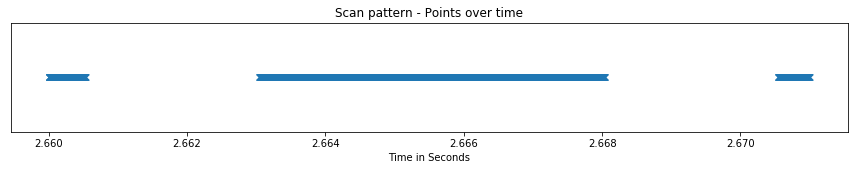

In [22]:
# This plots the time distribution of points
one_scan = first_return_df[(first_return_df['adj_gps_time'] > 2.66)&(first_return_df['adj_gps_time'] < 2.671)]
plt.figure(figsize=[15,2])
plt.plot(one_scan['adj_gps_time'],np.ones(len(one_scan)),'x')
plt.title("Scan pattern - Points over time")
plt.xlabel("Time in Seconds")
plt.tick_params(
    axis='y',          
    which='both',    
    left=False,      
    labelleft=False)

Text(0.5, 1.0, 'Points without a pulse')

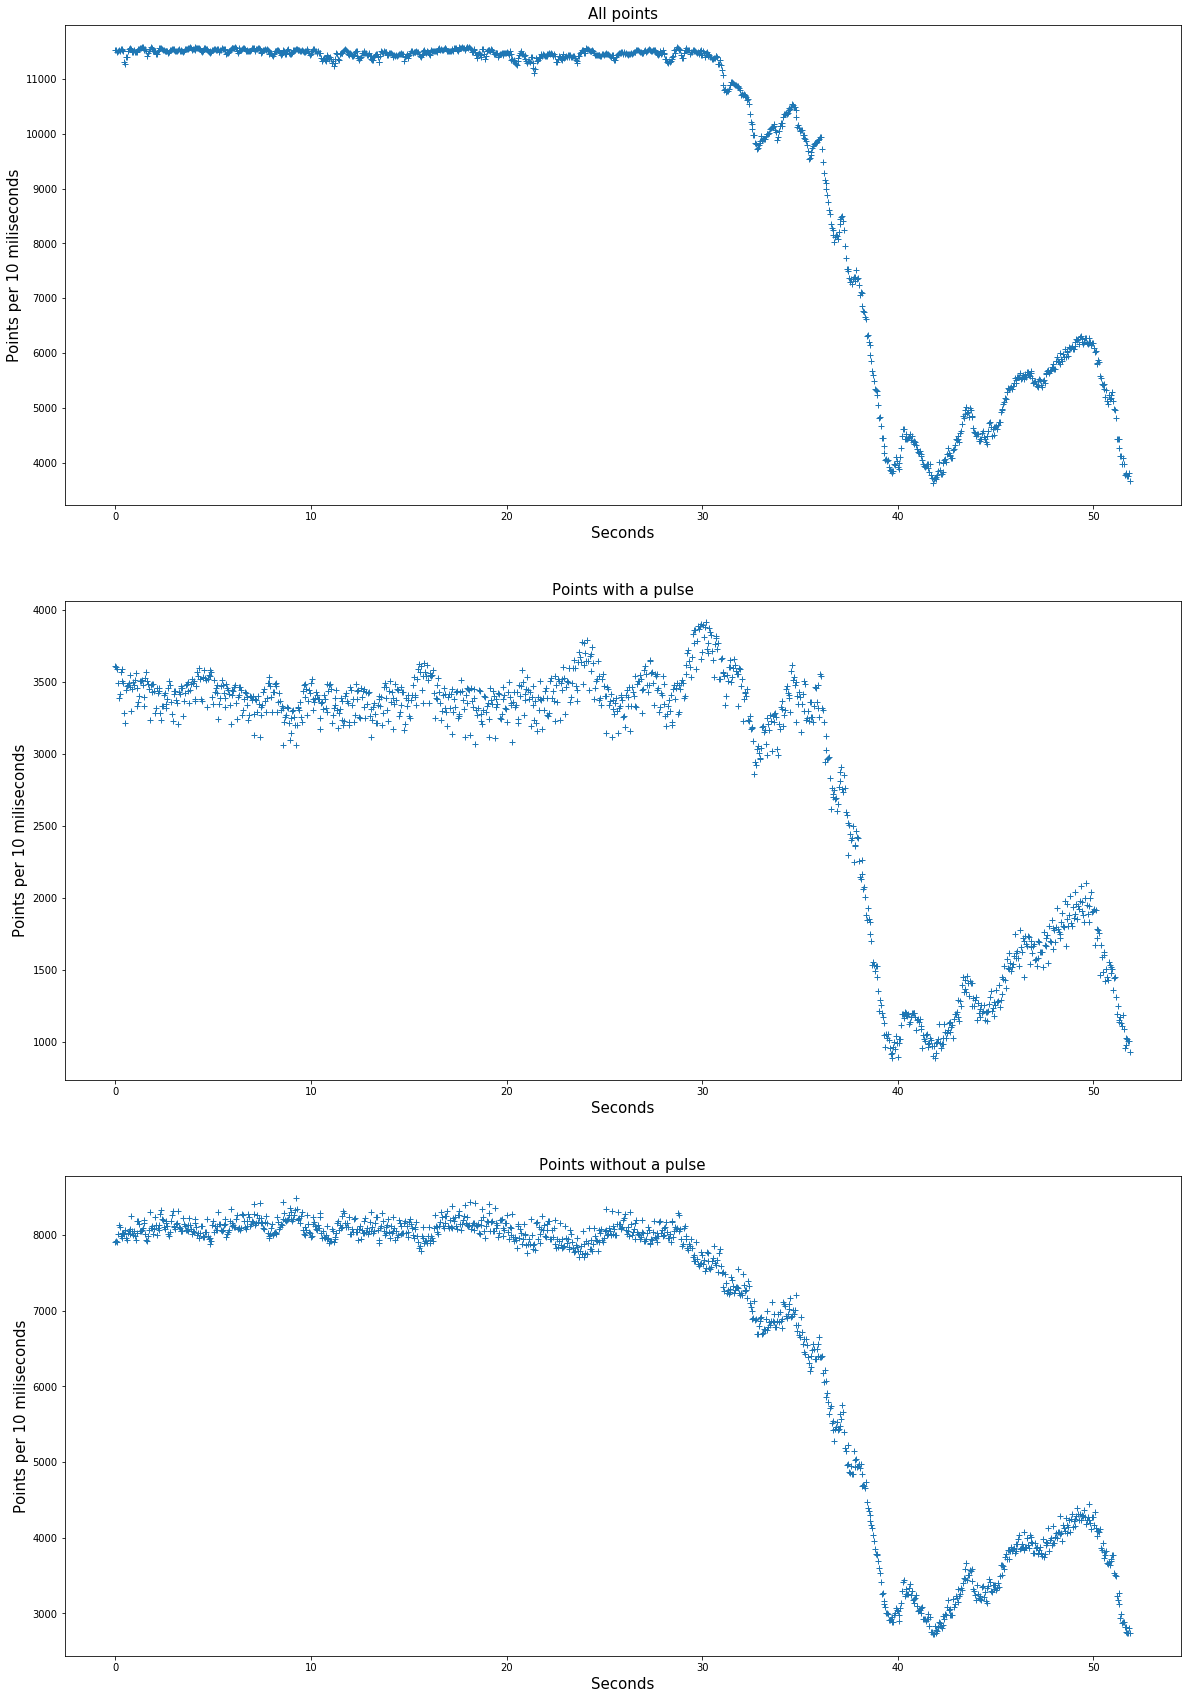

In [23]:
# Plot all points, points w/ pulse, and points w/o pulse in subplots
plt.figure(figsize=(20,30))
plt.subplot(3, 1, 1)
plt.plot(bin_arr[:-1],hist,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("All points",fontsize=15)

plt.subplot(3, 1, 2)
plt.plot(bin_arr[:-1],hist_with_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points with a pulse",fontsize=15)

plt.subplot(3, 1, 3)
plt.plot(bin_arr[:-1],hist_no_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points without a pulse",fontsize=15)

Text(0.5, 1.0, 'Temporal distribution of points/pulses from one flight')

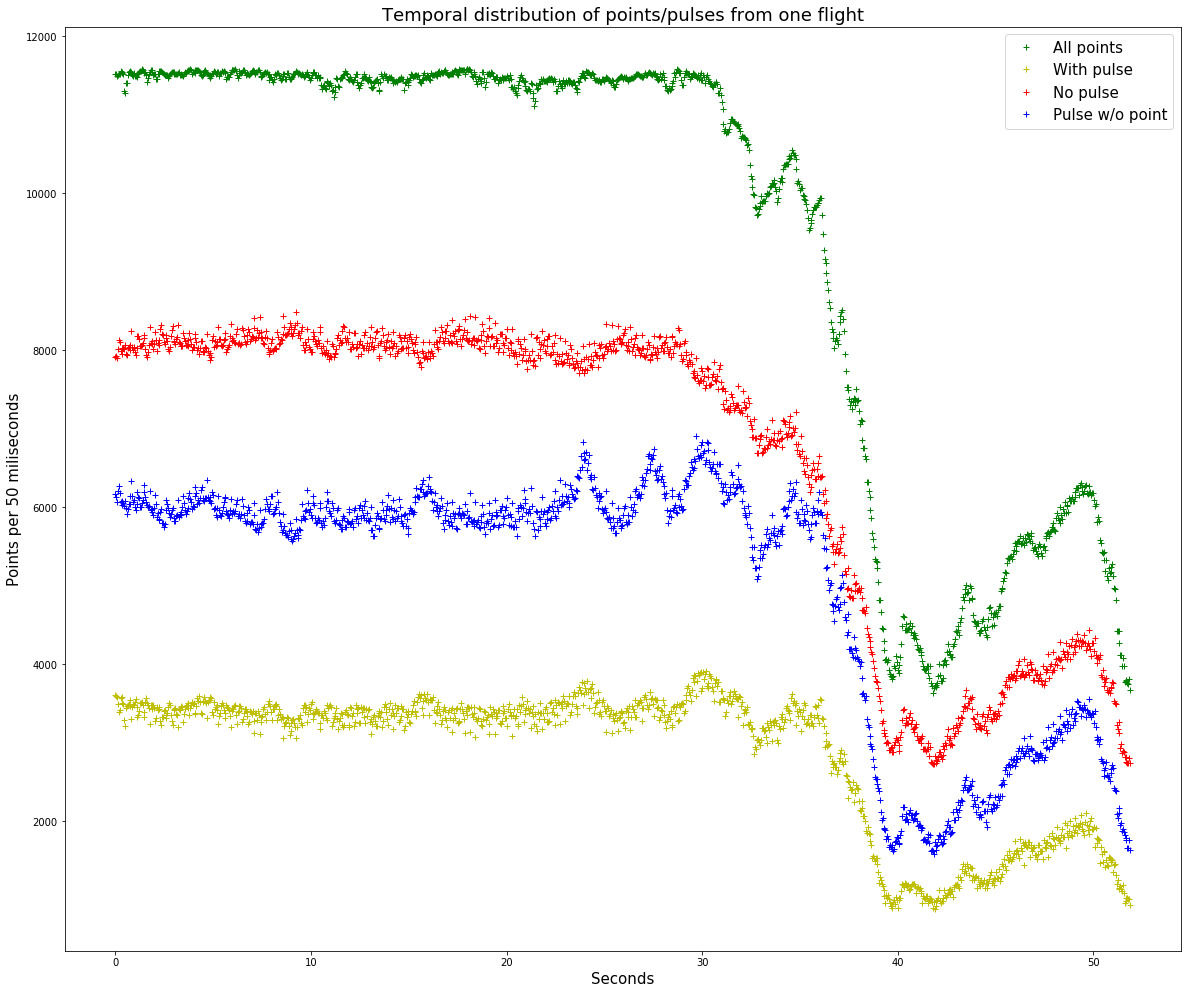

In [24]:
# Plot all points, and decomposed into with/without a corresponding pulse.  Also includes points with no pulse.

plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.plot(bin_arr[:-1],hist_with_pulse,'y+',label="With pulse")
plt.plot(bin_arr[:-1],hist_no_pulse,'r+',label="No pulse")
plt.plot(bin_arr[:-1],hist_pls_no_pt,'b+',label="Pulse w/o point")

plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.legend(fontsize=15)
plt.title("Temporal distribution of points/pulses from one flight",fontsize=18)

Text(0.5, 1.0, 'Temporal distribution of pulses from one flight')

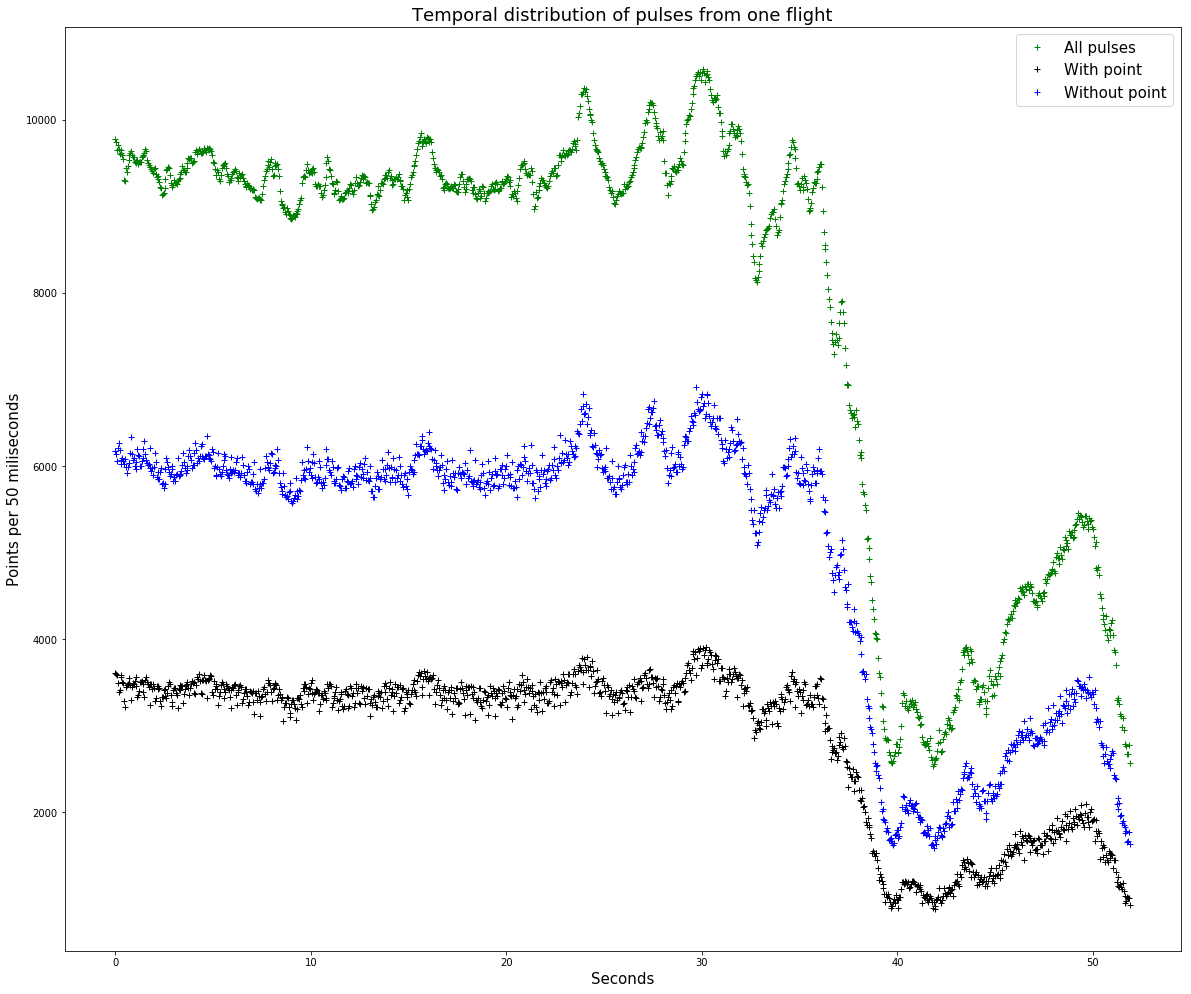

In [25]:
# Plot all pulses, and decomposed into with/without a corresponding point
plt.figure(figsize=(20,17))


plt.plot(bin_arr[:-1],hist_pulse,'g+',label="All pulses")
plt.plot(bin_arr[:-1],hist_pls_with_pt,'k+',label="With point")
plt.plot(bin_arr[:-1],hist_pls_no_pt,'b+',label="Without point")

plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.legend(fontsize=15)
plt.title("Temporal distribution of pulses from one flight",fontsize=18)

Text(0.5, 1.0, 'Temporal distribution of points from one flight')

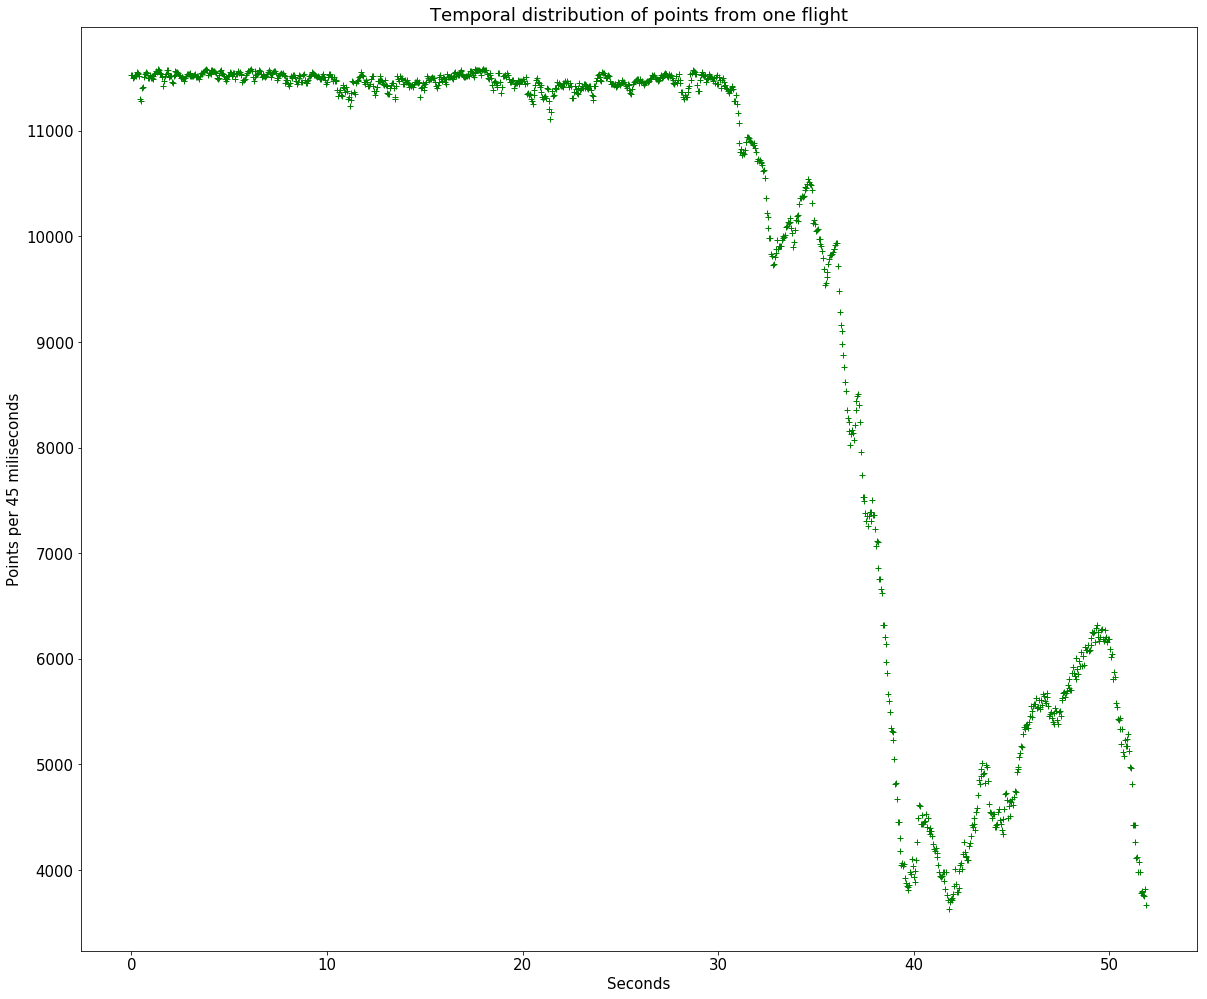

In [26]:
# Plot all the points, full flight path
plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 45 miliseconds",fontsize=15)
plt.title("Temporal distribution of points from one flight",fontsize=18)